# Linear Regression: Predicting Player Market Values

## What is Linear Regression?
Linear regression is a fundamental supervised learning algorithm that models the relationship between a dependent variable (target) and one or more independent variables (features). It works by:
1. Finding the best-fitting line through the data points
2. Minimizing the mean squared error between predictions and actual values
3. Providing continuous value predictions

## Our Task
We'll use linear regression to predict player market values based on their attributes. This regression task will demonstrate how we can estimate continuous values (market prices) based on player statistics.

## Implementation

In [205]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def identity(z):
	return z

def mean_squared_error(y_hat, y):
	return 0.5 * (y_hat - y)**2

class SingleNeuron(object):
	def __init__(self, activation_function, cost_function):
		self.activation_function = activation_function
		self.cost_function = cost_function

	def train(self, X, y, alpha = 0.005, epochs = 50):
		self.w_ = np.random.rand(1 + X.shape[1])
		self.errors_ = []
		N = X.shape[0]

		for _ in range(epochs):
			errors = 0
			for xi, target in zip(X, y):
				error = (self.predict(xi) - target)
				# print(error)
				# print(self.predict(xi), target)
				self.w_[:-1] -= alpha*error*xi
				self.w_[-1] -= alpha*error
				errors += self.cost_function(self.predict(xi), target)
			self.errors_.append(errors/N)
		return self

	def predict(self, X):
		preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
		# print("DDD", preactivation, X)
		return self.activation_function(preactivation)

## Understanding Our Dataset
Let's examine the key attributes we'll use to predict player market values:
- Overall Rating (primary indicator of player quality)
- Key Performance Stats (pace, shooting, passing, dribbling, defending, physical)
- Age (younger players often have higher market value potential)

We'll use these attributes to predict the market value of players. The relationship between these features and market value is expected to be roughly linear, making linear regression a suitable choice.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

players_df = pd.read_csv("../data/players_data.csv")
# print(players_df.sort_values('overall', ascending=False)[['short_name', 'overall', 'age', 'value_eur']].iloc[:15])

# Select features for prediction
features = ["overall", "age", "league_level", "club_contract_valid_until_year"]
# Remove rows with NaN or null values
filtered_df = players_df.dropna(subset=features + ['value_eur'])
X = filtered_df[features].values
y = filtered_df['value_eur'].values

# Scale features and target because they are too big for mse
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.93, random_state=42)
# print(X_train[:5])
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1277, 4)
Test set shape: (16973, 4)


/var/folders/pz/s1ggtx853xx_qxny9g89ffgm0000gn/T/ipykernel_32969/2308915508.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  players_df = pd.read_csv("../data/players_data.csv")


## Model Training

In [207]:
# Set the Seaborn theme
sns.set_theme()

# Instantiate and train the linear regression model
reg = SingleNeuron(activation_function=identity, cost_function=mean_squared_error)
reg.train(X_train, y_train, epochs=1000, alpha=0.0005)

## Error during training
The model converges very early in the process. I tried smaller alpha values but figured there was no point as they converged not too far off.

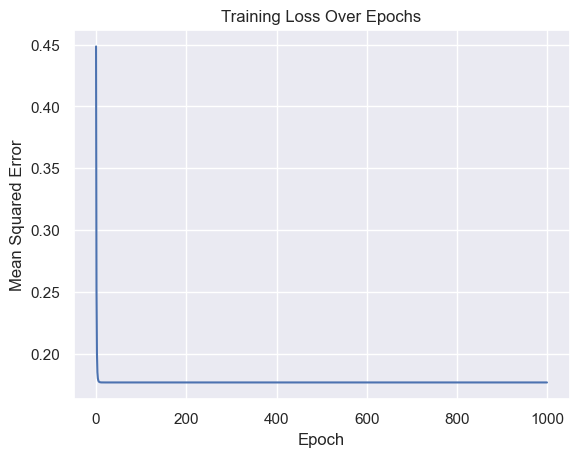

In [208]:
plt.plot(reg.errors_)
# print(reg.errors_)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()


## Feature Importance Analysis
Let's analyze which features have the strongest influence on player market values.

We see that the rating holds the most weight in our logistic regression model. This is reasonable as players with higher ratings are more likely to have higher market values.
Right after that is age, which also makes sense as younger players are worth more.

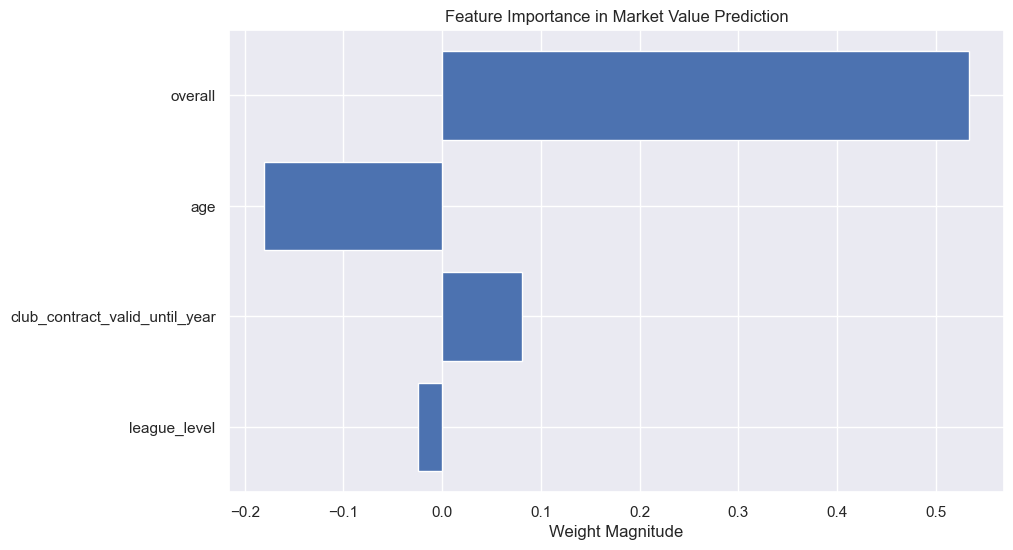

In [209]:
# print(reg.errors_)
# Feature importance plot
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'Feature': features,
    'Weight': reg.w_[:-1]  # excluding bias weight
})
feature_importance = feature_importance.sort_values('Weight', ascending=True, key=abs)

plt.barh(feature_importance['Feature'], feature_importance['Weight'])
plt.title('Feature Importance in Market Value Prediction')
plt.xlabel('Weight Magnitude')
plt.show()

## Model Performance Evaluation

Let's plot the most important feature(overall) against the market value.
The grren points are against the actual market values for the players while the red ones are our predicted.

By the eye test, our model seems average at best. This makes sense as the market value is not a complete linear relationship but more of a complex one between variables, including some we may not have captured here. Maybe a neural network would work better?

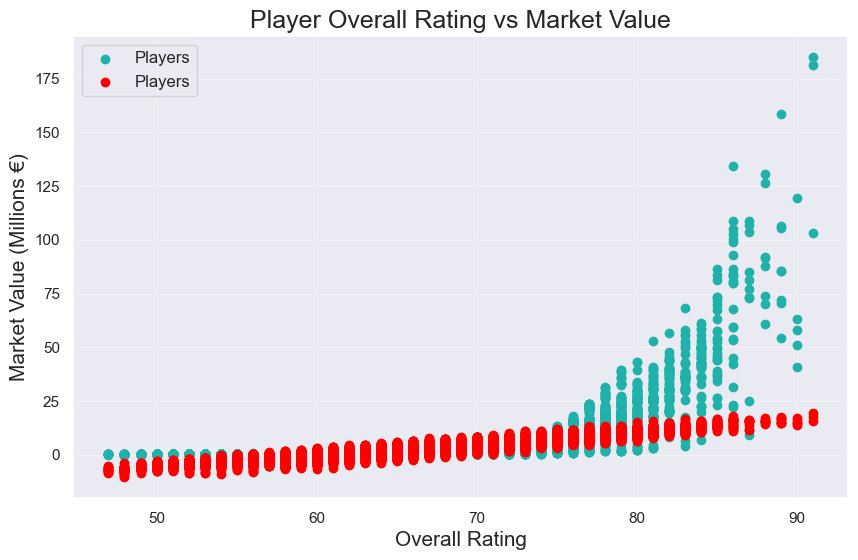

In [210]:
# Plot overall rating vs actual market value
plt.figure(figsize=(10, 6))

# Get original scale values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
X_test_original = scaler_X.inverse_transform(X_test)
overall_ratings = X_test_original[:, 0]  # overall rating is first feature

# Convert market values to millions for better visualization
y_test_millions = y_test_original / 1_000_000

# Create scatter plot of actual values
plt.scatter(overall_ratings, y_test_millions, color='lightseagreen', label='Players')

y_pred = reg.predict(X_test)
y_pred_millions = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel() / 1_000_000
plt.scatter(overall_ratings, y_pred_millions, color='red', label='Players')

plt.xlabel('Overall Rating', fontsize=15)
plt.ylabel('Market Value (Millions €)', fontsize=15)
plt.title('Player Overall Rating vs Market Value', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
# plt.tight_layout()
plt.show()